# Logit Orders 

To figure out the impact of `wait_time` and `delay_vs_expected` on very good and very bad reviews, I will run two multivariate logistic regressions (`logit_one` and `logit_five`) to predict `dim_is_one_star` and `dim_is_five_star` respectively.

In [1]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [3]:
from olist.order import Order
orders = Order().get_training_data(with_distance_seller_customer=True)
orders.columns

Index(['order_id', 'order_delivered_customer_date', 'wait_time',
       'expected_wait_time', 'delay_vs_expected', 'order_status',
       'dim_is_five_star', 'dim_is_one_star', 'review_score',
       'number_of_products', 'number_of_sellers', 'price', 'freight_value',
       'distance_seller_customer'],
      dtype='object')

Select which features avoiding data-leaks|

In [4]:
features = ['wait_time', "delay_vs_expected", "number_of_sellers", "distance_seller_customer", "price", "freight_value"]

Check the multi-colinearity of the features, using the `VIF index`. It shouldn't be too high (< 10 preferably) to ensure we can trust the partial regression coefficents and their associated `p-values` 

The variance inflation factor is a measure for the increase of the variance of the parameter estimates if an additional variable, given by exog_idx is added to the linear regression. It is a measure for multicollinearity of the design matrix, exog.

One recommendation is that if VIF is greater than 5, then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables, and the parameter estimates will have large standard errors because of this.

In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
X = orders[features]
X

,wait_time,delay_vs_expected,number_of_sellers,distance_seller_customer,price,freight_value
0,8.436574,0.0,1,18.063837,29.99,8.72
1,13.782037,0.0,1,856.292580,118.70,22.76
2,9.394213,0.0,1,514.130333,159.90,19.22
3,13.208750,0.0,1,1822.800366,45.00,27.20
4,2.873877,0.0,1,30.174037,19.90,8.72
...,...,...,...,...,...,...
96528,8.218009,0.0,1,69.481037,72.00,13.08
96529,22.193727,0.0,1,474.098245,174.90,20.10
96530,24.859421,0.0,1,968.051192,205.99,65.02
96531,17.086424,0.0,1,370.146853,359.98,81.18


In [9]:
df = pd.DataFrame()
df["vif_index"] = [vif(X.values, i) for i in range(X.shape[1])]
df["features"] = X.columns
df

,vif_index,features
0,6.944987,wait_time
1,2.262767,delay_vs_expected
2,4.309666,number_of_sellers
3,2.850947,distance_seller_customer
4,1.723233,price
5,2.869877,freight_value


Fit two LOGIT models (`logit_one` and `logit_five`) to predict `dim_is_one_star` and `dim_is_five_star`

In [10]:
logit_one = smf.logit(formula='dim_is_one_star ~'+ ' + '.join(features), data=orders).fit()
print(logit_one.summary())

Optimization terminated successfully.
         Current function value: 0.282467
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:        dim_is_one_star   No. Observations:                96525
Model:                          Logit   Df Residuals:                    96518
Method:                           MLE   Df Model:                            6
Date:                Sun, 25 Jul 2021   Pseudo R-squ.:                  0.1346
Time:                        22:25:42   Log-Likelihood:                -27265.
converged:                       True   LL-Null:                       -31505.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -5.1538      0.069    -74.957      0.000      -5.289

In [11]:
logit_five = smf.logit(formula='dim_is_five_star ~'+ ' + '.join(features), data=orders).fit()
print(logit_five.summary())

Optimization terminated successfully.
         Current function value: 0.638844
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       dim_is_five_star   No. Observations:                96525
Model:                          Logit   Df Residuals:                    96518
Method:                           MLE   Df Model:                            6
Date:                Sun, 25 Jul 2021   Pseudo R-squ.:                 0.05668
Time:                        22:25:53   Log-Likelihood:                -61664.
converged:                       True   LL-Null:                       -65370.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.4310      0.064     37.961      0.000       2.305

Interpret your results:

delay_vs_expected influences five_star ratings even more than one_star ratings

All other thing being equal, the delay factor tends to increase the chances of getting stripped of the 5-star even more so than it affect the chances of 1-star reviews. Probably because 1-stars are really targeting bad products themselves, not bad deliveries

In [12]:
linear_model = smf.ols('review_score ~'+ ' + '.join(features), data=orders).fit()
print(logit_one.summary())
print((('-----'*20) +'\n')*3)
print(linear_model.summary())

                           Logit Regression Results                           
Dep. Variable:        dim_is_one_star   No. Observations:                96525
Model:                          Logit   Df Residuals:                    96518
Method:                           MLE   Df Model:                            6
Date:                Sun, 25 Jul 2021   Pseudo R-squ.:                  0.1346
Time:                        22:29:44   Log-Likelihood:                -27265.
converged:                       True   LL-Null:                       -31505.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   -5.1538      0.069    -74.957      0.000      -5.289      -5.019
wait_time                    0.0727      0.002     41.627      0.000       0.069       0.

<AxesSubplot:title={'center':'Logit'}>

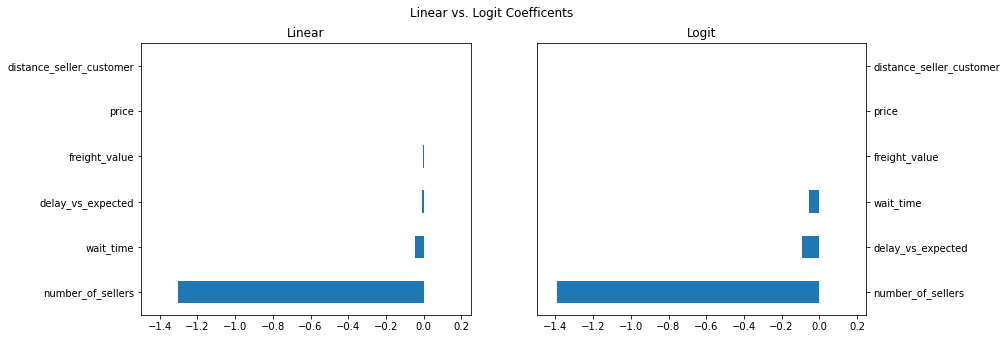

In [13]:
plt.figure(figsize=(13,5))
plt.suptitle('Linear vs. Logit Coefficents')
ax1 = plt.subplot(1,2,1)
ax1.set_title('Linear')
ax1.set_xlim(-1.5, 0.25)
linear_model.params[1:].sort_values().plot(kind='barh', ax=ax1)


ax2 = plt.subplot(1,2,2)
ax2.set_title('Logit')
ax2.yaxis.tick_right()
ax2.set_xlim(-1.5, 0.25)
logit_five.params[1:].sort_values().plot(kind='barh', ax=ax2)

Side by side comparison of our different models tell similar stories, with ~13% of the variance being explained through the selected features (as seen in the R-squared) and similar feature importance returning in the models' coefficients